# Running TCAV


This notebook walks you through things you need to run TCAV. In high level, you need:

1. **example images in each folder**
 * images for each concept
 * images for the class/labels of interest
 * random images that will be negative examples when learning CAVs (images that probably don't belong to any concepts)
2. **model wrapper**: an instance of  ModelWrapper abstract class (in model.py). This tells TCAV class (tcav.py) how to communicate with your model (e.g., getting internal tensors)
3. **act_generator**: an instance of ActivationGeneratorInterface that tells TCAV class how to load example data and how to get activations from the model



## Requirements

    Install sklearn and PIL before running below!

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import cav as cav
import model as model
import tcav as tcav
import utils as utils
import utils_plot as utils_plot # utils_plot requires matplotlib
import os
import torch
import activation_generator as act_gen
import tensorflow as tf

## Step 1. Store concept and target class images to local folders

and tell TCAV where they are.

**source_dir**: where images of concepts, target class and random images (negative samples when learning CAVs) live. Each should be a sub-folder within this directory.

Note that random image directories can be in any name. In this example, we are using `random500_0`, `random500_1`,.. for an arbitrary reason. 


You need roughly 50-200 images per concept and target class (10-20 pictures also tend to work, but 200 is pretty safe).


**cav_dir**: directory to store CAVs (`None` if you don't want to store)

**target, concept**: names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir

**bottlenecks**: list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.



In [38]:
working_dir = '/Users/grantbaum/Desktop/tcav_class_test'
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
source_dir = "/Users/grantbaum/Desktop/image_net_subsets/"
bottlenecks = ['Mixed_5d', 'Conv2d_2a_3x3']
      
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# this is a regularizer penalty parameter for linear classifier to get CAVs. 
alphas = [0.1]   

target = 'African elephant'  
concepts = ["concept_1"]
random_counterpart = 'random500_0'


LABEL_PATH = working_dir + '/imagenet_comp_graph_label_strings.txt'

In [39]:
mymodel = model.InceptionV3Wrapper(LABEL_PATH)

## Step 3. Implement a class that returns activations (maybe with caching!)

Lastly, you will implement a class of the ActivationGenerationInterface which TCAV uses to load example data for a given concept or target, call into your model wrapper and return activations. I pulled out this logic outside of mymodel because this step often takes the longest. By making it modular, you can cache your activations and/or parallelize your computations, as I have done in `ActivationGeneratorBase.process_and_load_activations` in `activation_generator.py`.


The `process_and_load_activations` method of the activation generator must return a dictionary of activations that has concept or target name as  a first key, and the bottleneck name as a second key. So something like:

```python
{concept1: {bottleneck1: [[0.2, 0.1, ....]]},
concept2: {bottleneck1: [[0.1, 0.02, ....]]},
target1: {bottleneck1: [[0.02, 0.99, ....]]}
```


In [40]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

## You are ready to run TCAV!

Let's do it.

**num_random_exp**: number of experiments to confirm meaningful concept direction. TCAV will search for this many folders named `random500_0`, `random500_1`, etc. You can alternatively set the `random_concepts` keyword to be a list of folders of random concepts. Run at least 10-20 for meaningful tests. 

**random_counterpart**: as well as the above, you can optionally supply a single folder with random images as the "positive set" for statistical testing. Reduces computation time at the cost of less reliable random TCAV scores. 


In [41]:
tf.logging.set_verbosity(0)

num_random_exp=2 # folders (random500_0, random500_1)

mytcav = tcav.TCAV(target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)

results = mytcav.run()

['/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_50.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03796401_13.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_46.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_6.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_11.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03796401_8.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_3.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_32.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03706229_16.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_14.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_24.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_12.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_22.JPEG', '/Users/grantbaum/Desktop/image_net_subs


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

['/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_50.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03796401_13.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_46.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_6.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_11.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03796401_8.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_3.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_32.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03706229_16.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_14.JPEG', '/Users/grantbaum/Desktop/

['/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_50.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03796401_13.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_46.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_6.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_11.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03796401_8.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_3.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_32.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03706229_16.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_14.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_24.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_12.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_22.JPEG', '/Users/grantbaum/Desktop/image_net_subs

['/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_50.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03796401_13.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_46.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_6.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_11.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03796401_8.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_3.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_32.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03706229_16.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_14.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_24.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_12.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_22.JPEG', '/Users/grantbaum/Desktop/image_net_subs

['/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_50.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03796401_13.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_46.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_6.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_11.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03796401_8.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_3.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_32.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03706229_16.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_14.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_24.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_12.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_22.JPEG', '/Users/grantbaum/Desktop/image_net_subs

['/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_50.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03796401_13.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_46.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_6.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02730930_11.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03796401_8.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_3.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_32.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03706229_16.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_14.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_24.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n02815834_12.JPEG', '/Users/grantbaum/Desktop/image_net_subsets/concept_1/n03814639_22.JPEG', '/Users/grantbaum/Desktop/image_net_subs

Class = African elephant
  Concept = concept_1
    Bottleneck = Mixed_5d. TCAV Score = 0.48 (+- 0.01), random was 0.53 (+- 0.04). p-val = 0.342 (not significant)
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.51 (+- 0.02), random was 0.48 (+- 0.05). p-val = 0.679 (not significant)


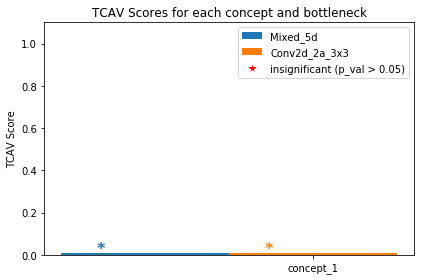

In [42]:
utils_plot.plot_results(results, num_random_exp=num_random_exp)

# Result
### Based on concept created from random selection of images

Above graphs and TCAV is not at all meaningful because I chose random assortment of pictures from Imagenet to represent the concept. I also had to manually set the concept path in activation_generator.py so that needs to be fixed. This represents 1 random (meaningless concept) being tested on the class African elephant. 